In [62]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
# load english language model in spacy 
nlp = spacy.load('en_core_web_sm')
# importing recommended libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sn

In [37]:
# v = CountVectorizer()
# v = CountVectorizer(ngram_range=(2,2))
v = CountVectorizer(ngram_range=(1,3))

data = ['Thor Hathodawala is looking for a job', 'Hello World']
v.fit_transform(data)
v.vocabulary_

{'thor': 14,
 'hathodawala': 2,
 'is': 7,
 'looking': 11,
 'for': 0,
 'job': 10,
 'thor hathodawala': 15,
 'hathodawala is': 3,
 'is looking': 8,
 'looking for': 12,
 'for job': 1,
 'thor hathodawala is': 16,
 'hathodawala is looking': 4,
 'is looking for': 9,
 'looking for job': 13,
 'hello': 5,
 'world': 17,
 'hello world': 6}

In [38]:
def preprocess(text):
    doc = nlp(text)

    filtered_tokens = []
  
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    # list covert to string
    return ' '.join(filtered_tokens)

preprocess('Thor Hathodawala is looking for a job')

'Thor Hathodawala look job'

In [39]:
# collection of documents
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [40]:
corpus_processed = [preprocess(text) for text in corpus]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [41]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

**Converting text to number**

In [42]:
v.transform(['Thor eat pizza']).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]])

**Out Of vocabular problem**

In [43]:
v.transform(['Hulk eat pizza']).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

#### __Perform n gram by building model in large DB__

#### __News Category Classification Problem__
Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

1. BUSINESS
1. SPORTS
1. CRIME
1. SCIENCE

#### Dataset

Dataset Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

- This data consists of two columns.
        - Text
        - Category
- Text is a news article
- Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original dataset

In [44]:
df = pd.read_json('data/news_dataset.json')
# lines = True means each line is a json object

df.shape
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


**Finding the dataset is imablanced or not**

In [45]:
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

**Undersampling the dataset to balanced the dataset**

### **Handle class imbalance**

As you can see above, SCIENCE category has almost 1/3rd data samples compared to BUSINESS and SPORTS categories. I initially trained a model without handling the imbalanced I saw a lower f1-score for SCIENCE category. Hence we need to address this imbalanced. 

There are various ways of handling class imbalance which I have discussed in this video: https://www.youtube.com/watch?v=JnlM4yLFNuo


Out of those techniques, I will use **undersampling** technique here. 

In undersampling, we take a minor class and sample those many samples from other classes, this means we are not utilizing all the data samples for training and in ML world - Not using all the data for training is considered a SIN! 😵 In real life, you are advised to use a technique such as SMOTE so that you can utilize all of your dataset for the training but since this tutorial is more about bag of n-grams then class imbalance itself, I'd go with a simple technique of undersampling. 

In [46]:
min_samples = 1381

df_business = df[df['category'] == 'BUSINESS'].sample(min_samples, random_state=2023)
df_sports = df[df['category'] == 'SPORTS'].sample(min_samples, random_state=2023)
df_crime = df[df['category'] == 'CRIME'].sample(min_samples, random_state=2023)
df_science = df[df['category'] == 'SCIENCE'].sample(min_samples, random_state=2023)
# random_state=42 means same random samples will be selected each time
# random_sate = None means random samples will be selected each time, default value is None
# random_state = 0 means same random samples will be selected each time
# random_state = 1 means same random samples will be selected each time
# random_state = 2 means same random samples will be selected each time

In [47]:
df_balanced = pd.concat([df_business, df_sports, df_crime, df_science], axis=0)
# axis = 0 means concat along rows
# axis = 1 means concat along columns

df_balanced.shape
df_balanced.head(100)
df_balanced

,text,category
11110,Why Trendspotting Still Matters: The Power of ...,BUSINESS
6472,Software That Helps Travelers and Companies Se...,BUSINESS
7863,The Secret to Greater Success Is... Learning H...,BUSINESS
7920,Megyn Kelly Has The Perfect One-Word Response ...,BUSINESS
5459,How to Find Your Next Super Star Employee The ...,BUSINESS
...,...,...
8055,Breathtaking Time-Lapse Video Shows How Sunris...,SCIENCE
4714,Watch A NASA Booster Nozzle Plug Get Blown To ...,SCIENCE
6437,These Are NASA's Favorite Earth Photos Of 2015...,SCIENCE
4067,All The Mathematical Methods I Learned In My U...,SCIENCE


In [48]:
df_balanced['category'].value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

**Converting category into value**

In [49]:
# mappin the 
df_balanced['category_new'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1,
    'CRIME': 2,
    'SCIENCE': 3
})

df_balanced[1380:1382]

,text,category,category_new
12687,"Get Even I was in debt. Serious debt. The ""how...",BUSINESS,0
11398,Colin Kaepernick Receives Amnesty Internationa...,SPORTS,1


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced['category_new'], 
    test_size = 0.2, 
    random_state = 2023,
    stratify = df_balanced['category_new']
)
# stratify=df_balanced['category_new'] means same distribution(we will see equal number of these 4 types(BUSINESS, SPORTS, CRIME, SCIENCE) of category in both tain and test dataset) of classes in train and test

In [51]:
y_train.value_counts()
# here we can see that we have equal number of these 4 types(BUSINESS, SPORTS, CRIME, SCIENCE) of category in train dataset

category_new
0    1105
1    1105
2    1105
3    1104
Name: count, dtype: int64

In [52]:
y_test.value_counts()

category_new
3    277
2    276
1    276
0    276
Name: count, dtype: int64

**Naive Bayes classifications recommended for text based classification**

**Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model**

In [53]:
# creating a pipeline
model = Pipeline([
    ('vectorizer_bow', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# training the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       276
           1       0.88      0.83      0.85       276
           2       0.85      0.87      0.86       276
           3       0.89      0.81      0.85       277

    accuracy                           0.85      1105
   macro avg       0.85      0.85      0.85      1105
weighted avg       0.85      0.85      0.85      1105



**Attempt 2 : Use 1-gram to bigrams**

In [54]:
# creating a pipeline
model = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),
    ('classifier', MultinomialNB())
])

# training the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       276
           1       0.90      0.77      0.83       276
           2       0.86      0.85      0.86       276
           3       0.89      0.77      0.83       277

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



**Attempt 3 : Use 1-gram to tigrams**

In [55]:
# creating a pipeline
model = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1,3))),
    ('classifier', MultinomialNB())
])

# training the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.77       276
           1       0.91      0.76      0.83       276
           2       0.86      0.84      0.85       276
           3       0.89      0.76      0.82       277

    accuracy                           0.82      1105
   macro avg       0.83      0.82      0.82      1105
weighted avg       0.83      0.82      0.82      1105



In [56]:
X_test[:5]

10873    When Mothers Kill While it's no surprise some ...
3735     18-Year-Old Confesses To Molesting 'Upwards Of...
4907     Spectacular Supermoon Gets 2018 Off To A Heave...
4586     Shooting Diamonds: Directing the World Series ...
5670     Kobe Bryant Feuds With Michael B. Jordan In Sp...
Name: text, dtype: object

In [57]:
y_test[:5]

10873    2
3735     2
4907     3
4586     1
5670     1
Name: category_new, dtype: int64

In [58]:
y_pred[:5]

array([0, 2, 1, 1, 1])

**Perform the model after preprocessing**
### Use text pre-processing to remove stop words, punctuations and apply lemmatization

You may wonder, we have not done any text-processing yet to remove stop words, punctuations, apply lemmatization etc. Well we wanted to train the model without any preprocessing first and check the performance. Now we will re-do same thing but with preprocessing of text

In [59]:
df_balanced['preprocessed_text'] = df_balanced['text'].apply(preprocess)

In [60]:
df_balanced.head()

,text,category,category_new,preprocessed_text
11110,Why Trendspotting Still Matters: The Power of ...,BUSINESS,0,Trendspotting matter Power look Forward archai...
6472,Software That Helps Travelers and Companies Se...,BUSINESS,0,software help Travelers company Selling Travel...
7863,The Secret to Greater Success Is... Learning H...,BUSINESS,0,Secret Greater Success learn sell important su...
7920,Megyn Kelly Has The Perfect One-Word Response ...,BUSINESS,0,Megyn Kelly Perfect Word Response Donald Trump...
5459,How to Find Your Next Super Star Employee The ...,BUSINESS,0,find Super Star Employee pace talent scouting ...


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_text, 
    df_balanced['category_new'], 
    test_size = 0.2, 
    random_state = 2023,
    stratify = df_balanced['category_new']
)


# creating a pipeline
model = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range=(1,2))),
    ('classifier', MultinomialNB())
])

# training the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       276
           1       0.90      0.83      0.86       276
           2       0.82      0.91      0.86       276
           3       0.89      0.82      0.85       277

    accuracy                           0.85      1105
   macro avg       0.86      0.85      0.85      1105
weighted avg       0.86      0.85      0.85      1105



**We have seen, doing preprocesing the acurracy of model is increased. So, generally we have to do preprocessing**

If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

**Plot confusion matrix**

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[237,  11,  17,  11],
       [ 12, 228,  25,  11],
       [ 14,   5, 250,   7],
       [ 27,  10,  12, 228]])

Text(95.72222222222221, 0.5, 'Truth')

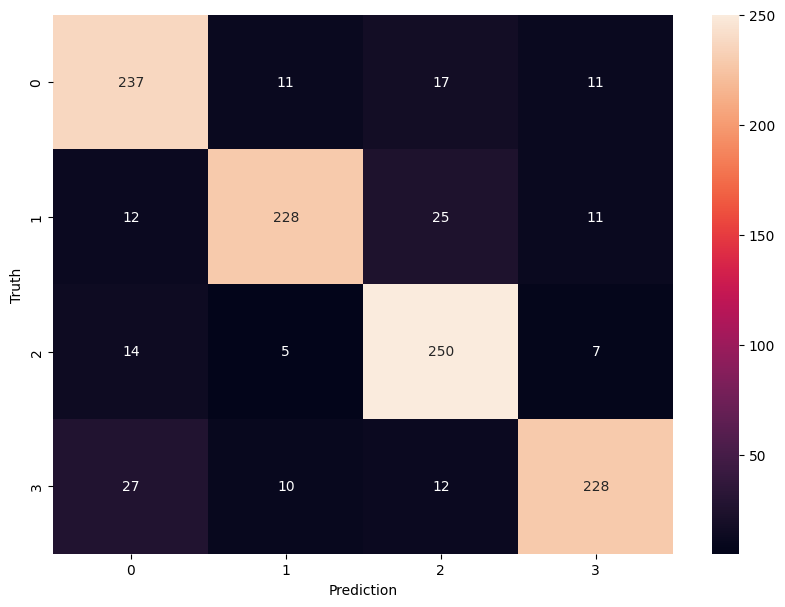

In [64]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')